<a href="https://colab.research.google.com/github/HoViet0107/hieu/blob/main/ReviewsCrawl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Link Colab with Google Drive


In [ ]:
from google.colab import drive\

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install scrapy
!pip install requests
!pip install underthesea
!pip install pyvi

     |████████████████████████████████| 2.6 MB 4.5 MB/s 
     |████████████████████████████████| 895 kB 33.8 MB/s 
     |████████████████████████████████| 636 kB 42.6 MB/s 
     |████████████████████████████████| 3.3 MB 49.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 254 kB 4.7 MB/s 
     |████████████████████████████████| 65 kB 3.0 MB/s 
     |████████████████████████████████| 3.2 MB 8.4 MB/s 
     |████████████████████████████████| 47 kB 4.0 MB/s 
     |████████████████████████████████| 3.2 MB 50.3 MB/s 
     |████████████████████████████████| 3.1 MB 43.8 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 251 kB 45.0 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
  Created wheel for protego: filename=Protego-0.1.16-py3-none-any.whl size=7783 sha256=b43ab63e79e1bb9830bca

In [ ]:
import scrapy
import requests
import json
import pandas as pd
import numpy as np
from pyvi import ViTokenizer

import re
from underthesea import word_tokenize #word_tokenize of lines

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import pickle
from sklearn.metrics import f1_score, accuracy_score
from sklearn.externals import joblib #load, dump pkl



/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


###Crawl Data

In [ ]:
TIKI_REVIEWS_API_URL = 'https://tiki.vn/api/v2/reviews?product_id={}?&page={}'

def get_reviews(url, page, reviews):
    prod_id = url.split('-p')[1].split('.html')[0]
    headers = {
        'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36'
    }
    response = requests.get(TIKI_REVIEWS_API_URL.format(prod_id, page), headers=headers)
    res_body = json.loads(response.content)
    last_page = res_body['paging']['last_page']
    reviews = reviews + res_body['data']
    reviews_count = res_body['reviews_count']
    #print(reviews_count)
    #i=0
    res = []
    if reviews_count == 0:
        print('Not has comment!')
        quit()

    for review in reviews:
      if (review['content'] != "" or review['content'].strip()):
        res += [review['content']]
        #i+=1
      elif (review['content'] == "" and review['rating'] == 5 ):
        res += ["Cực kì hài lòng"]
      elif (review['content'] == "" and review['rating'] == 4 ):
        res += ["Hài lòng"]
      elif (review['content'] == "" and review['rating'] == 3 ):
        res += ["Bình thường"]
      elif (review['content'] == "" and review['rating'] == 5 ):
        res += ["Không hài lòng"]
      elif (review['content'] == "" and review['rating'] == 5 ):
        res += ["Rất không hài lòng"]
    arr = []
    if page < last_page:
        arr = get_reviews(url, page+1, reviews)
    else:
        return res
    return arr


###Standard data, tokenizer

In [ ]:
def standardize_data(row):
    #Remove all . , " ... in sentences
    row = row.replace(",", " ").replace(".", " ") \
          .replace(";", " ").replace("“", " ") \
          .replace(":", " ").replace("”", " ") \
          .replace('"', " ").replace("'", " ") \
          .replace("!", " ").replace("?", " ") \
          .replace("-", " ").replace("?", " ").replace(" 🏻"," ")

    #Remove các từ kéo dài như đẹppppp -> đẹp
    row = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), row, flags=re.IGNORECASE)

    #Lowercase
    row = row.lower()

    #Chuẩn hóa tiếng Việt, xử lý emoj, chuẩn hóa tiếng Anh, thuật ngữ
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        'ak': 'à',
        #Quy các icon về 3 loại emoj: Tích cực tiêu cực và trung lâp
        "👻": "positive", "💃": "positive",'🤙': ' positive ', '👍': ' positive ',
        "💄": "neutral", "💎": "neutral", "💩": "positive","😕": "negative", "😱": "negative", "😸": "positive",
        "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "neutral", "🧡": "positive",'🐶':' neuutral ',
        '👎': ' negative ', '😣': ' negative ','✨': ' positive ', '❣': ' positive ','☀': ' positive ',
        '♥': ' positive ', '🤩': ' positive ', 'like': ' positive ', '💌': ' neutral ',
        '🤣': ' positive ', '🖤': ' positive ', '🤤': ' positive ', ':(': ' negative ', '😢': ' negative ',
        '❤': ' positive ', '😍': ' positive ', '😘': ' positive ', '😪': ' negative ', '😊': ' positive ',
        '?': ' ? ', '😁': ' positive ', '💖': ' positive ', '😟': ' negative ', '😭': ' negative ',
        '💯': ' positive ', '💗': ' positive ', '♡': ' positive ', '💜': ' positive ', '🤗': ' positive ',
        '^^': ' positive ', '😨': ' negative ', '☺': ' positive ', '💋': ' positive ', '👌': ' positive ',
        '😖': ' negative ', '😀': ' positive ', ':((': ' negative ', '😡': ' negative ', '😠': ' negative ',
        '😒': ' negative ', '🙂': ' posiive ', '😏': ' negative ', '😝': ' positive ', '😄': ' positive ',
        '😙': ' positive ', '😤': ' negative ', '😎': ' positive ', '😆': ' positive ', '💚': ' positive ',
        '✌': ' positive ', '💕': ' positive ', '😞': ' negative ', '😓': ' negative ', '️🆗️': ' positive ',
        '😉': ' positive ', '😂': ' positive ', ':v': '  positive ', '=))': '  positive ', '😋': ' positive ',
        '💓': ' positive ', '😐': ' neutral ', ':3': ' positive ', '😫': ' negative ', '😥': ' negative ',
        '😃': ' positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': ' positive ', '🤝': ' positive ', '🎈': ' positive ',
        '😗': ' positive ', '🤔': ' negative ', '😑': ' negative ', '🔥': ' negative ', '🙏': ' negative ',
        '🆗': ' positive ', '😻': ' positive ', '💙': ' positive ', '💟': ' positive ',
        '😚': ' positive ', '❌': ' negative ', '👏': ' positive ', ';)': ' positive ', '<3': ' positive ',
        '🌝': ' positive ',  '🌷': ' positive ', '🌸': ' positive ', '🌺': ' positive ',
        '🌼': ' neutral ', '🍓': ' positive ', '🐅': ' positive ', '🐾': ' positive ', '👉': ' positive ',
        '💐': ' positive ', '💞': ' positive ', '💥': ' positive ', '💪': ' positive ',
        '💰': ' positive ',  '😇': ' positive ', '😛': ' positive ', '😜': ' positive ',
        '🙃': ' positive ', '🤑': ' positive ', '🤪': ' positive ','☹': ' negative ',  '💀': ' negative ',
        '😔': ' negative ', '😧': ' neutral ', '😩': ' negative ', '😰': ' negative ', '😳': ' neutral ',
        '😵': ' neutral', '😶': ' neutral ', '🙁': ' neutral ',

        #Chuẩn hóa 1 số sentiment words/English words
        ':))': '  positive ', ':)': ' positive ', 'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'not': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ','khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' negative ',' cc ': ' negative ','cute': u' dễ thương ','huhu': ' negative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ', 'đuoc': u'được' , 'mn': u'mọi người',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ','nice' : u' tốt ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
        #quy chuan sao thanh star
        '5 sao': ' 5star ','5 star': ' 5star ','5sao': ' 5star ', '4 star': ' 4star ','4 sao': ' 4star ','3sao': ' 3star ','3 star': ' 3star ','3 sao': ' 3star ','3sao': ' 3star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 2star ','2sao':' 2star ',
        '2 starstar':' 2star ','1star': ' 1star ',}

    for k, v in replace_list.items():
        row = row.replace(k, v)

    row = row.strip()
    return row

# Tokenizer
def tokenizer(row):
    #return word_tokenize(row, format="text")
    return  ViTokenizer.tokenize(row)


###Process Data

In [ ]:
def processing_data(data):
    #Standardize data
    data_frame = pd.DataFrame(data)
    #print('dataframe':, data_frame)
    data_frame[0] = data_frame[0].apply(standardize_data)

    #Tokenizer
    data_frame[0] = data_frame[0].apply(tokenizer)
    return data_frame[0]

###TF-IDF *Vectorized*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#Load TF-IDF weight
tf_idf = pickle.load(open("/content/drive/MyDrive/tfidf.pk", "rb"))


###Predict

In [ ]:
def predict(url):
    #Load URL and print comments
    data = get_reviews(url, 1, [])
    data = processing_data(data)

    #predict
    pl = pickle.load(open("/content/drive/MyDrive/hieu1.sav", "rb"))
    X_test_tfidf = tf_idf.transform(data)
    print(X_test_tfidf.shape)
    y_pred = pl.predict(X_test_tfidf)

    cols = ['content', 'label']
    test_data = pd.DataFrame(columns=cols)
    test_data['label'] = y_pred
    test_data['content'] = data
    return test_data

###Analyst Data

In [ ]:
import wordcloud
import matplotlib.pyplot as plt
def analyze(test_data):
    print(test_data)
    #statistic
    neu_count = test_data['label'].value_counts()[3]
    pos_count = test_data['label'].value_counts()[1]
    neg_count = test_data['label'].value_counts()[2]
    print("Positive reviews  😊: ", pos_count)
    print("Negative reviews  😡: ", neg_count)
    print("Neutral reviews   😐: ", neu_count)
    #Pie chart
    pie_chart = np.array([pos_count, neg_count,neu_count])
    mylabels = ["Positive", "Negative", "Neutral"]
    myexplode = [0.2, 0, 0]
    plt.pie(pie_chart, labels = mylabels, shadow = True, startangle= 90, autopct = '%1.1f%%')
    plt.show()
    print("--------------------------------------")

    #Rating predict:
    rating = float((pos_count*5+neg_count*1.5+neu_count*3.5)/(pos_count+neg_count+neu_count))

    print("Rating Predict: ",round(rating,1),"⭐")

    #suggestion for customer:
    if rating > 4:
        print("Good! You can buy it! 👌👌👌")
    elif (rating > 2 and rating <= 4):
        print("Please check it carefully! ❗❗❗")
    elif (rating <= 2):
        print("Bad! 👎👎👎")
    print("--------------------------------------")

    #Create word cloud
    neg_word = test_data['content'].loc[test_data['label']==2]
    pos_word = test_data['content'].loc[test_data['label']==1]
    neu_word = test_data['content'].loc[test_data['label']==3]

    stop_ws = (u'rằng',u'thì',u'là',u'mà',u'mình',u'bé',u'cho',u'chỉ',u'em',u'và',u'gì',u'này',u'bị',u'các',u'cái',u'cần',u'càng',u'cho',u'chiếc',u'chứ',u'ng',u'cùng',u'cũng'
          ,u'gì',u'của',u'còn',u'có',u'cũng',u'khi',u'sẽ',u'về',u'với',u'để',u'nên',u'thêm',u'con',u'nữa',u'sau',u'so',u'tôi',u'vì',u'vẫn',u'đã',u'lần',u'lại',u'bằng',u'biết'
          ,u'do',u'người',u'ra',u'tiki',u'vậy',u'trên',u'trong',u'giống',u'cả',u'bên',u'giờ',u'nào',u'rồi',u'đầu',u'bộ',u'một',u'như',u'đi',u'đơn',u'đây'
          ,u'vừa',u'đó',u'dc',u'dùng',u'ghi',u'hơi',u'hơn',u'hộp',u'loại',u'luôn',u'làm',u'lên',u'lúc',u'lắm',u'máy',u'mẫu',u'mở',u'ngoài',u'ngày',u'nhiều',u'nhà',u'nhìn',u'nói'
          ,u'nước',u'phải',u'qua',u'sao',u'thấy',u'trước',u'tới',u'từ',u'vào',u'vừa',u'xem',u'xong',u'bạn',u'chính',u'chơi',u'hang',u'mọi',u'mới',u'nhé',u'quá'
          ,u'tầm',u'ai',u'bạn',u'báo',u'dán',u'kg',u'miếng',u'mấy',u'mặc',u'nó',u'phần',u'tháng',u'tiếng',u'đến',u'xe',u'bh',u'cáo')
    #Extract Feature using Tf-idf
    tfidf_pos = TfidfVectorizer(ngram_range=(1, 5), min_df=4, max_df= 0.9, stop_words= stop_ws, max_features= 100, sublinear_tf=True , smooth_idf=True)
    tfidf_neg = TfidfVectorizer(ngram_range=(1, 5), min_df=2, max_df= 0.9, stop_words= stop_ws, max_features= 100, sublinear_tf=True , smooth_idf=True)
    tfidf_neu = TfidfVectorizer(ngram_range=(1, 5), min_df=3, max_df= 0.9, stop_words= stop_ws, max_features= 100, sublinear_tf=True , smooth_idf=True)

    tfidf_matrix_pos =  tfidf_pos.fit_transform(pos_word)
    tfidf_matrix_neg =  tfidf_neg.fit_transform(neg_word)
    tfidf_matrix_neu =  tfidf_neu.fit_transform(neu_word)

    feature_names_pos = tfidf_pos.get_feature_names()
    feature_names_neg = tfidf_neg.get_feature_names()
    feature_names_neu = tfidf_neu.get_feature_names()

    #Create WordCloud for Positive reviews
    print("Postive Review :")
    print(feature_names_pos)
    #%matplotlib inline
    cloud = np.array(feature_names_pos)
    plt.figure(figsize=(12,6))
    plt.title("WordCloud for Positive Reviews")
    word_cloud = wordcloud.WordCloud(max_words=30,background_color ="black",
                 width=1200,height=600,mode="RGB").generate(str(cloud))
    plt.axis("off")
    plt.imshow(word_cloud)
    print("--------------------------------------")

    #Create WordCloud for Negative reviews
    print("Negative Review :")
    print(feature_names_neg)
    #%matplotlib inline
    cloud = np.array(feature_names_neg)
    plt.figure(figsize=(12,6))
    plt.title("WordCloud for Negative Reviews")
    word_cloud = wordcloud.WordCloud(max_words=30,background_color ="black",
                 width=1200,height=600,mode="RGB").generate(str(cloud))
    plt.axis("off")
    plt.imshow(word_cloud)
    print("--------------------------------------")
    #Create WordCloud for Neutral reviews
    print("Neutral Review :")
    print(feature_names_neu)
    #%matplotlib inline
    cloud = np.array(feature_names_neu)
    plt.figure(figsize=(12,6))
    plt.title("WordCloud for Neutral Reviews")
    word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                 width=1200,height=600,mode="RGB").generate(str(cloud))
    plt.axis("off")
    plt.imshow(word_cloud)


(303, 4098)
                                               content  label
0    rất tin_dùng nước xả downy hông có gì bàn cải ...      2
1    giao hàng nhanh đặt hôm trước hôm sau có luôn ...      1
2    hàng gia_dụng giá tạm ổn giao hàng đóng_gói tố...      3
3    vừa nhận hàng mở ra là can đã móp như hình khô...      2
4    nước xả thơm lắm nha săn sale tiki nên giá ổn ...      3
..                                                 ...    ...
298                                    cực_kì hài_lòng      1
299                                    cực_kì hài_lòng      1
300                                        bình_thường      3
301                                    cực_kì hài_lòng      1
302                                    cực_kì hài_lòng      1

[303 rows x 2 columns]
Positive reviews  😊:  260
Negative reviews  😡:  13
Neutral reviews   😐:  30


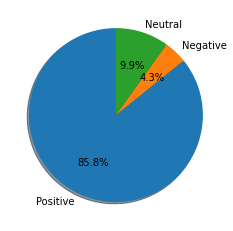

--------------------------------------
Rating Predict:  4.7 ⭐
Good! You can buy it! 👌👌👌
--------------------------------------
Postive Review :
['chất_lượng', 'cám_ơn', 'cám_ơn cửa_hàng', 'cẩn_thận', 'cửa_hàng', 'cực_kì', 'cực_kì hài_lòng', 'downy', 'giao', 'giao hàng', 'giao hàng nhanh', 'giao nhanh', 'giá', 'giá rẻ', 'gói', 'gói hàng', 'hài_lòng', 'hàng', 'hàng nhanh', 'hương', 'kèm', 'lâu', 'mua', 'mùi', 'mùi thơm', 'nhanh', 'nhanh đóng_gói', 'nhanh đóng_gói cẩn_thận', 'nhân_viên', 'nhân_viên giao', 'nhân_viên giao hàng', 'ok', 'positive', 'rất', 'rất thơm', 'rẻ', 'sản_phẩm', 'sản_phẩm tốt', 'thơm', 'tặng', 'tốt', 'xả', 'xả thơm', 'đóng_gói', 'đóng_gói cẩn_thận', 'ủng_hộ']
--------------------------------------
Negative Review :
['chai', 'chất_lượng', 'cửa_hàng', 'giao', 'hàng', 'khuyến_mãi', 'không', 'kèm', 'nha', 'quà', 'quà tặng', 'rất', 'sản_phẩm', 'tặng', 'xả']
--------------------------------------
Neutral Review :
['giao', 'giao hàng', 'giá', 'hài_lòng', 'hàng', 'hương', 'khô

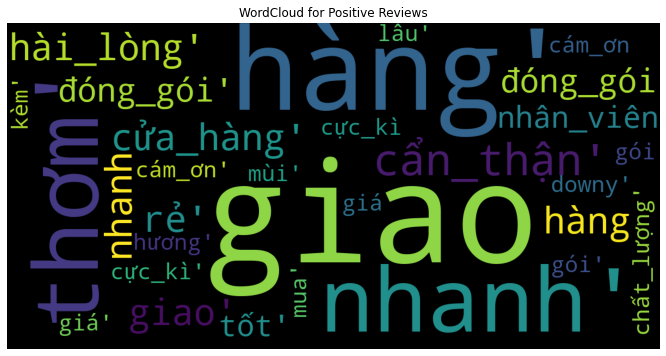

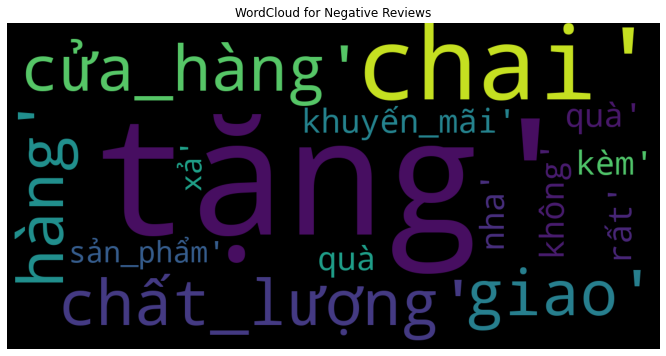

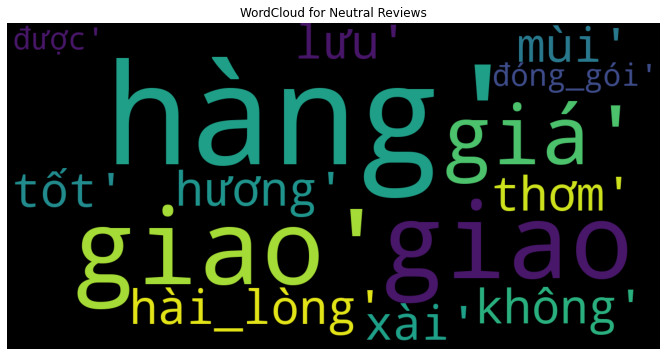

In [ ]:
data = predict('https://tiki.vn/nuoc-xa-vai-downy-huong-nuoc-hoa-quyen-ru-4l-dang-chai-p72040480.html')
data.to_csv('/content/drive/MyDrive/tiki.csv', index=False)
analyze(data)